In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [2]:
# Paramètres
IMG_HEIGHT = 300
IMG_WIDTH = 300
NUM_CLASSES = 3  # Nombre de classes mis à jour

In [3]:
# Chemins des dossiers 
covid_path = '/Users/eloicadamjee/Downloads/COVID-19_Radiography_Dataset/COVID/images'
covid_mask = '/Users/eloicadamjee/Downloads/COVID-19_Radiography_Dataset/COVID/masks'
normal_path = '/Users/eloicadamjee/Downloads/COVID-19_Radiography_Dataset/Normal/images'
normal_mask = '/Users/eloicadamjee/Downloads/COVID-19_Radiography_Dataset/Normal/masks'
lung_opacity_path = '/Users/eloicadamjee/Downloads/COVID-19_Radiography_Dataset/Lung_Opacity/images'
lung_opacity_mask = '/Users/eloicadamjee/Downloads/COVID-19_Radiography_Dataset/Lung_Opacity/masks'
viral_pneumonia_path = '/Users/eloicadamjee/Downloads/COVID-19_Radiography_Dataset/Viral Pneumonia/images'
viral_pneumonia_mask = '/Users/eloicadamjee/Downloads/COVID-19_Radiography_Dataset/Viral Pneumonia/masks'

In [4]:
# Vérification des chemins 
paths = [covid_path, normal_path, lung_opacity_path, viral_pneumonia_path]
for path in paths:
    if os.path.exists(path):
        print(f"Img chemin existe: {path}")
    else:
        print(f"Img chemin n'existe pas: {path}")


# Vérifier que les chemins des masques existent
mask_paths = [covid_mask, normal_mask, lung_opacity_mask, viral_pneumonia_mask]
for mask_path in mask_paths:
    if os.path.exists(mask_path):
        print(f"Mask chemin existe: {mask_path}")
    else:
        print(f"Mask chemin n'existe pas: {mask_path}")

Img chemin existe: /Users/eloicadamjee/Downloads/COVID-19_Radiography_Dataset/COVID/images
Img chemin existe: /Users/eloicadamjee/Downloads/COVID-19_Radiography_Dataset/Normal/images
Img chemin existe: /Users/eloicadamjee/Downloads/COVID-19_Radiography_Dataset/Lung_Opacity/images
Img chemin existe: /Users/eloicadamjee/Downloads/COVID-19_Radiography_Dataset/Viral Pneumonia/images
Mask chemin existe: /Users/eloicadamjee/Downloads/COVID-19_Radiography_Dataset/COVID/masks
Mask chemin existe: /Users/eloicadamjee/Downloads/COVID-19_Radiography_Dataset/Normal/masks
Mask chemin existe: /Users/eloicadamjee/Downloads/COVID-19_Radiography_Dataset/Lung_Opacity/masks
Mask chemin existe: /Users/eloicadamjee/Downloads/COVID-19_Radiography_Dataset/Viral Pneumonia/masks


In [7]:
# Afficher les tailles des images en Ko et Mo
def display_image_sizes(images):
    sizes_bytes = [img.nbytes for img in images]
    sizes_ko = [size / 1024 for size in sizes_bytes]
    sizes_mo = [size / (1024 * 1024) for size in sizes_bytes]
    
    for i, (size_b, size_ko, size_mo) in enumerate(zip(sizes_bytes, sizes_ko, sizes_mo)):
        print(f"Image {i+1} - Taille: {size_b} octets, {size_ko:.2f} Ko, {size_mo:.2f} Mo")

display_image_sizes(images[:10])  # Afficher les tailles des 10 premières images

Image 1 - Taille: 2160000 octets, 2109.38 Ko, 2.06 Mo
Image 2 - Taille: 2160000 octets, 2109.38 Ko, 2.06 Mo
Image 3 - Taille: 2160000 octets, 2109.38 Ko, 2.06 Mo
Image 4 - Taille: 2160000 octets, 2109.38 Ko, 2.06 Mo
Image 5 - Taille: 2160000 octets, 2109.38 Ko, 2.06 Mo
Image 6 - Taille: 2160000 octets, 2109.38 Ko, 2.06 Mo
Image 7 - Taille: 2160000 octets, 2109.38 Ko, 2.06 Mo
Image 8 - Taille: 2160000 octets, 2109.38 Ko, 2.06 Mo
Image 9 - Taille: 2160000 octets, 2109.38 Ko, 2.06 Mo
Image 10 - Taille: 2160000 octets, 2109.38 Ko, 2.06 Mo


In [5]:
# Fonction pour charger les images et les masques
def load_images_with_masks(image_dir, mask_dir, label, limit=None):
    image_data = []
    label_data = []
    image_files = os.listdir(image_dir)
    if limit:
        image_files = image_files[:limit]
    for file_name in image_files:
        if file_name.endswith('.png'):
            img_path = os.path.join(image_dir, file_name)
            mask_path = os.path.join(mask_dir, file_name)
            try:
                img = cv2.imread(img_path)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
                mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
                img = img / 255.0
                mask = mask / 255.0
                lung_only = img * np.expand_dims(mask, axis=-1)  # Garder uniquement la partie des poumons
                image_data.append(lung_only)
                label_data.append(label)
                # Calculer la taille de l'image
                image_size = os.path.getsize(img_path) / 1024  # Taille en Ko
                print(f"Taille de l'image {file_name}: {image_size:.2f} Ko")
            except Exception as e:
                print(f"Erreur de chargement de l'image {file_name} ou du masque : {e}")
    return np.array(image_data), np.array(label_data)

# Fonction pour charger les données de plusieurs répertoires avec masques
def load_data_with_masks(image_dirs, mask_dirs, labels, limits=None):
    all_images = []
    all_labels = []
    for i in range(len(image_dirs)):
        images, label_data = load_images_with_masks(image_dirs[i], mask_dirs[i], labels[i], limits[i])
        all_images.append(images)
        all_labels.append(label_data)
    return np.concatenate(all_images), np.concatenate(all_labels)

# Nouvelles étiquettes après regroupement
new_labels = [0, 1, 2, 2]  # 0 pour COVID, 1 pour Normal, 2 pour Lung Opacity + Viral Pneumonia

# Définir les limites par classe
limits = [2500, 2500, 1250, 1250]  # 2500 images par classe

In [6]:
# Charger et prétraiter les données avec les nouvelles étiquettes
images, labels = load_data_with_masks([covid_path, normal_path, lung_opacity_path, viral_pneumonia_path],
                                       [covid_mask, normal_mask, lung_opacity_mask, viral_pneumonia_mask],
                                       new_labels, limits)

Taille de l'image COVID-1.png: 27.55 Ko
Taille de l'image COVID-1175.png: 37.04 Ko
Taille de l'image COVID-1613.png: 39.28 Ko
Taille de l'image COVID-948.png: 25.40 Ko
Taille de l'image COVID-790.png: 34.42 Ko
Taille de l'image COVID-3004.png: 37.29 Ko
Taille de l'image COVID-3010.png: 39.49 Ko
Taille de l'image COVID-1607.png: 33.56 Ko
Taille de l'image COVID-784.png: 34.69 Ko
Taille de l'image COVID-1161.png: 32.22 Ko
Taille de l'image COVID-2468.png: 23.64 Ko
Taille de l'image COVID-1149.png: 39.71 Ko
Taille de l'image COVID-2440.png: 31.76 Ko
Taille de l'image COVID-3038.png: 41.56 Ko
Taille de l'image COVID-2326.png: 37.13 Ko
Taille de l'image COVID-974.png: 32.94 Ko
Taille de l'image COVID-960.png: 32.73 Ko
Taille de l'image COVID-2332.png: 37.15 Ko
Taille de l'image COVID-2454.png: 41.46 Ko
Taille de l'image COVID-753.png: 32.41 Ko
Taille de l'image COVID-1808.png: 32.08 Ko
Taille de l'image COVID-747.png: 35.67 Ko
Taille de l'image COVID-2483.png: 38.35 Ko
Taille de l'image COV

In [7]:
# Vérifiez les tailles des ensembles de données
print(f"Nombre d'images chargées: {images.shape[0]}")
print(f"Nombre de labels: {len(labels)}")

Nombre d'images chargées: 7499
Nombre de labels: 7499


In [9]:
# Aplatir les images pour les utiliser avec Random Forest
X = images.reshape(images.shape[0], -1)
y = labels

print(f"Taille de X après aplatissement: {X.shape}")
print(f"Taille de y: {len(y)}")

Taille de X après aplatissement: (7499, 270000)
Taille de y: 7499


In [10]:
# Encoder les étiquettes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [11]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Taille de X_train: {X_train.shape}")
print(f"Taille de X_test: {X_test.shape}")
print(f"Taille de y_train: {len(y_train)}")
print(f"Taille de y_test: {len(y_test)}")

Taille de X_train: (5249, 270000)
Taille de X_test: (2250, 270000)
Taille de y_train: 5249
Taille de y_test: 2250


In [12]:
# Créer et entraîner le modèle Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# Prédire sur l'ensemble de test
y_pred = clf.predict(X_test)

In [14]:
# Évaluer le modèle
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")

Accuracy: 0.7315555555555555
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69       750
           1       0.74      0.75      0.74       750
           2       0.78      0.75      0.76       750

    accuracy                           0.73      2250
   macro avg       0.73      0.73      0.73      2250
weighted avg       0.73      0.73      0.73      2250



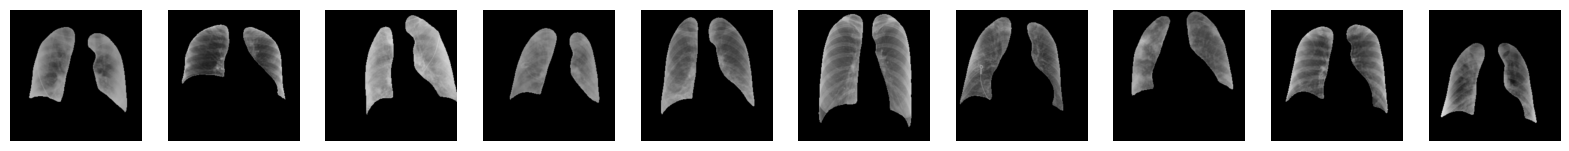

In [15]:
# Visualiser quelques images avec masques appliqués
def visualize_images_with_masks(images, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

visualize_images_with_masks(images[:10])  # Visualiser les 10 premières images

In [9]:
# Vérifiez les tailles des ensembles de données
print(f"Nombre d'échantillons dans X: {images.shape[0]}")
print(f"Nombre d'échantillons dans y: {len(labels)}")

Nombre d'échantillons dans X: 8844
Nombre d'échantillons dans y: 10000


In [10]:
# Aplatir les images pour les utiliser avec Random Forest
X = images.reshape(images.shape[0], -1)
y = labels

In [11]:
# Assurer que X et y ont la même longueur
# Assurer que X et y ont la même longueur
if X.shape[0] != len(y):
    raise ValueError("Les tailles des ensembles de données X et y ne correspondent pas.")

ValueError: Les tailles des ensembles de données X et y ne correspondent pas.

In [11]:
# Encoder les étiquettes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [12]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

ValueError: Found input variables with inconsistent numbers of samples: [8844, 9000]